<a href="https://colab.research.google.com/github/franciscogonzalez-gal/text_image_recognition/blob/main/Proyecto_Text_Mining_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problema 1

### 1) Montar Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Librerías

In [ ]:
import re
from collections import Counter
import pandas as pd


In [ ]:
import spacy
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["ner","parser"])  # solo tokenizer + lemmatizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# spaCy trae su propia lista de stopwords en inglés
# Stopwords ampliadas (además de las de spaCy):
extra_stop = {
    "rt","via","http","https","co","amp",
    "u","ur","im","i'm","ive","i’ve","id","i’d","ill","i’ll","ya","yall","y'all",
    "btw","thx","pls","plz","omg","lol","lmao","rofl","haha","hehe","kk",
    "hey","hi","hello","yo","ok","okay","k","ty","gtg","brb","bbl","tbh","ikr","idk","bday"
}
stop_words = nlp.Defaults.stop_words | extra_stop

### Ruta al archivo en tu carpeta "datos"

In [ ]:
# Ajusta el nombre del archivo CSV según corresponda
DATASET_PATH = '/content/drive/My Drive/datos/tw_source.csv'

### Parámetros


In [ ]:
CHUNKSIZE = 200_000
MENTION_RE = re.compile(r'@([A-Za-z0-9_]{1,15})')
WINDOW = 5
COLS = ['sentiment','id','date','query','user','text']
OUT_DIR = '/content/drive/My Drive/datos'


### Encontrar Top 3 usuarios más mencionados

In [ ]:
COLS = ['sentiment','id','date','query','user','text']

df = pd.read_csv(
    DATASET_PATH,
    header=None,
    names=COLS,
    encoding='latin-1',
    quotechar='"',
    escapechar='\\',
    engine='python',
    on_bad_lines='skip'   # salta filas rotas
)

print(df.shape)
print(df.head())
print(df.isna().sum())

(1599488, 6)
   sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64


In [ ]:
mentions_series = df['text'].astype(str).str.findall(MENTION_RE)
mention_counts = Counter(m.lower() for lst in mentions_series for m in lst)
top3 = [u for u, _ in mention_counts.most_common(3)]
print("Top 3 usuarios más mencionados:", [f"@{u}" for u in top3])
print("Frecuencias:", [mention_counts[u] for u in top3])

Top 3 usuarios más mencionados: ['@mileycyrus', '@tommcfly', '@ddlovato']
Frecuencias: [4579, 3904, 3474]


### Construcción de corpus y contexto

In [ ]:
# Subcadenas del handle objetivo, para excluir alias como "miley", "cyrus", etc.
def handle_substrings(handle: str, minlen: int = 3):
    s = re.sub(r'[^a-z0-9]', '', handle.lower())
    subs = set()
    for i in range(len(s)):
        for j in range(i + minlen, len(s) + 1):
            subs.add(s[i:j])
    return subs

# POS que conservamos
KEEP_POS = {"NOUN", "VERB", "ADJ"}

# Normalización de repeticiones ("goooood" -> "good")
repeat_re = re.compile(r'(.)\1{2,}', re.IGNORECASE)
def deelongate(w: str) -> str:
    return repeat_re.sub(r'\1\1', w)

def clean_and_filter(tokens, block_set):
    tmp = []
    for t in tokens:
        t = t.lower().strip()
        if not t:
            continue
        if t.startswith('http://') or t.startswith('https://'):
            continue
        if t.startswith('@') or t.startswith('#'):
            t = t[1:]
        t = deelongate(t)
        if len(t) <= 2 or not re.search('[a-z]', t):
            continue
        if t in stop_words or t in block_set:
            continue
        tmp.append(t)

    # Lematización + POS con spaCy
    doc = nlp(" ".join(tmp))
    out = []
    for tok in doc:
        if tok.pos_ not in KEEP_POS:
            continue
        lemma = tok.lemma_.lower().strip()
        if not lemma or lemma in stop_words or lemma in block_set:
            continue
        if not lemma.isalpha() or len(lemma) <= 2:
            continue
        out.append(lemma)
    return out



In [ ]:
# 4) Construcción de corpus y contexto
corpora = {u: [] for u in top3}
# Conteo por DF
context_df_counts = {u: Counter() for u in top3}

# Precalcula subcadenas a bloquear por usuario (derivadas del handle)
handle_blocks = {u: handle_substrings(u) for u in top3}

In [ ]:
for row in df.itertuples(index=False):
    text = str(row.text)

    # Menciones del tweet (con y sin @)
    mentions = {m.lower() for m in MENTION_RE.findall(text)}
    mentions_no_at = {m.lstrip('@') for m in mentions}

    # ¿Qué targets aparecen en este tweet?
    found_targets = [u for u in top3 if u in mentions]
    if not found_targets:
        continue

    # Tokenización completa para longitud e índices de @u
    doc_full = nlp(text)
    tokens = [t.text for t in doc_full]
    length_tokens = len(tokens)

    for u in found_targets:
        # Guardar corpus
        corpora[u].append({
            'id': str(row.id),
            'timestamp': row.date,
            'length': length_tokens,
            'text': text
        })

        # Bloqueo base: subcadenas del handle + todas las menciones del tweet
        block_set = set()
        block_set |= handle_blocks[u]
        block_set |= mentions
        block_set |= mentions_no_at

        # Contexto alrededor de cada aparición del objetivo
        indices = [k for k, t in enumerate(tokens) if t.lower() == f'@{u}']
        if not indices:
            continue

        tweet_terms = set()
        for k in indices:
            start = max(0, k - WINDOW)
            end = min(len(tokens), k + WINDOW + 1)

            # Ventana original con mayúsculas para detectar PROPN
            window_tokens_orig = tokens[start:k] + tokens[k+1:end]
            window_doc = nlp(" ".join(window_tokens_orig))

            # Añade a bloque todos los PROPN en la ventana (nombres propios y alias)
            for wd in window_doc:
                if wd.pos_ == "PROPN":
                    block_set.add(wd.text.lower())

            # Pasa por limpieza/lemmatización y acumula DF por tweet
            cleaned = clean_and_filter([w.text for w in window_doc], block_set)
            tweet_terms.update(cleaned)

        context_df_counts[u].update(tweet_terms)

### Mostrar Top-10 (DF) y WordClouds

In [ ]:
for u in top3:
    print(f"\n@{u} – Top 10 palabras de contexto (DF):")
    for w, c in context_df_counts[u].most_common(10):
        print(f"  {w}: {c}")


@mileycyrus – Top 10 palabras de contexto (DF):
  love: 275
  vote: 231
  good: 160
  come: 137
  feel: 79
  luck: 79
  wish: 76
  hope: 73
  know: 69
  look: 66

@tommcfly – Top 10 palabras de contexto (DF):
  good: 123
  come: 103
  love: 98
  think: 78
  reply: 74
  miss: 72
  guy: 71
  want: 62
  birthday: 61
  know: 60

@ddlovato – Top 10 palabras de contexto (DF):
  love: 173
  wish: 137
  come: 99
  good: 77
  want: 71
  wait: 67
  hope: 63
  know: 58
  vote: 52
  fun: 41


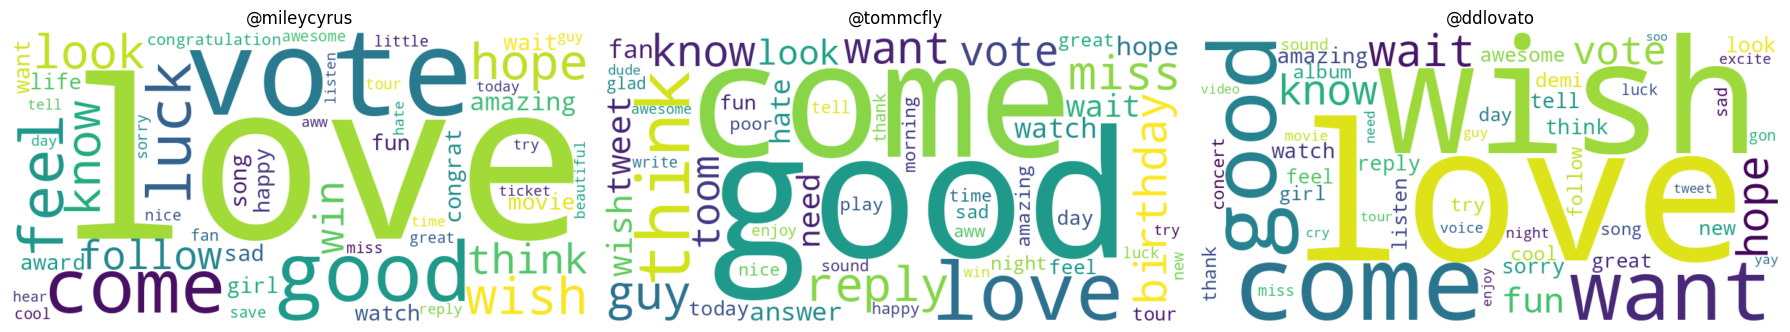

In [ ]:
# WordClouds basadas en DF
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(1, len(top3), figsize=(6*len(top3), 5))
if len(top3) == 1:
    axes = [axes]
for ax, u in zip(axes, top3):
    freqs = dict(context_df_counts[u].most_common(50)) or {'no_data': 1}
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(freqs)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'@{u}')
plt.tight_layout()
plt.show()

### Guardar corpus

In [ ]:
for u in top3:
    df_u = pd.DataFrame(corpora[u], columns=['id','timestamp','length','text'])
    out_path = f'{OUT_DIR}/corpus_{u}.csv'
    df_u.to_csv(out_path, index=False, encoding='utf-8')
    print(f'Corpus @{u} guardado en {out_path} con {len(df_u)} tweets')

Corpus @mileycyrus guardado en /content/drive/My Drive/datos/corpus_mileycyrus.csv con 4561 tweets
Corpus @tommcfly guardado en /content/drive/My Drive/datos/corpus_tommcfly.csv con 3898 tweets
Corpus @ddlovato guardado en /content/drive/My Drive/datos/corpus_ddlovato.csv con 3460 tweets
